# Nomor 2

## A.

Di sini, saya mengimport library yang dibutuhkan, set path dan parameter untuk preprocessing, dan kemudian melakukan preprocessing (resizing dan data augmentation).

Untuk data augmentation yang saya lakukan:
- Secara acak membalik gambar secara horizontal (kiri-kanan) dengan probabilitas yang di-set 50%.
- Kecerahan gambar diubah-ubah secara acak dengan nilai antara -0.1 sampai +0.1
- Kontras gambar diubah secara acak antara 0.9 sampai 1.1

Pertama, dilakukan preprocessing seperti mengubah warna jadi grayscale, dibagi 255.0 untuk menormalkan nilai pixel antara 0 dan 1, resizing ke 64 x 264, dan diberi label 0 & 1. Setelah itu, function augment dipanggil untuk melakukan data augmentation. Terakhir, images dikonversi ke array dan One-Hot Encoding.


In [58]:
# Import library
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# set variabel path dan parameter untuk cell bagian preprocessing
PATH = './parkinson_xray'
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 264
CHANNEL = 1  
label_class = ['NORMAL', 'PNEUMONIA']


In [60]:

def augment(image):
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast
    return image

images = []
class_list = []


for i, class_name in enumerate(label_class):
    class_path = os.path.join(PATH, class_name)
    for file in os.listdir(class_path):
     
        image = load_img(os.path.join(class_path, file), color_mode='grayscale')
        image = img_to_array(image) / 255.0  
        image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))

       
        images.append(image)
        class_list.append(i)  # Label (0 for NORMAL, 1 for PNEUMONIA)

        
        augmented_image = augment(image)
        images.append(augmented_image)
        class_list.append(i) 


X = np.asarray(images)
y = tf.keras.utils.to_categorical(class_list, num_classes=len(label_class))



## B.

Di sini, saya memisahkan dataset menjadi rasio 70:20:10, yaitu 70% untuk training, 20% untuk validation, 10% untuk testing.

In [61]:
# Split training, validation, testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # temp ke 20% val, 10% test

print(f"Training set: {X_train.shape} | Validation set: {X_val.shape} | Test set: {X_test.shape}")


Training set: (7302, 64, 264, 1) | Validation set: (2097, 64, 264, 1) | Test set: (1033, 64, 264, 1)


## C.

Di sini saya membuat arsitektur model CNN, mengkompilasinya, dan mendapatkan summary dari modelnya. Untuk arsitektur sendiri mengikuti instruksi soal, dan untuk specify padding = 2 di sini ditambahkan ZeroPadding2D untuk Conv2D pertama. Saya kemudian menjalankan training sebanyak 5 epoch.

Sebelum membuat arsitektur, saya mengubah label dari one-hot menjadi biner terlebih dahulu agar tidak ada "ValueError: logits and labels must have the same shape, received ((None, 1) vs (None, 2))." yang muncul ketika menggunakan binary_crossentropy untuk data berlabel one-hot encoding


In [62]:
# Ubah label ke bentuk biner
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)


# Bikin arsitektur
model = models.Sequential([
    layers.ZeroPadding2D(padding=2, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL)),
    layers.Conv2D(6, (5, 5), activation='relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    
    layers.Flatten(),
    
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

# Compile modelnya & mendapatkan summary tsb
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_2 (ZeroPaddi  (None, 68, 268, 1)       0         
 ng2D)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 264, 6)        156       
                                                                 
 average_pooling2d_4 (Averag  (None, 32, 132, 6)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 128, 16)       2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 14, 64, 16)       0         
 ePooling2D)                                                     
                                                      

In [63]:
# Train model 
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
229/229 [==============================] - 5s 19ms/step - loss: 0.3077 - accuracy: 0.8895 - val_loss: 0.2382 - val_accuracy: 0.9561
Epoch 2/5
229/229 [==============================] - 4s 18ms/step - loss: 0.1448 - accuracy: 0.9560 - val_loss: 0.0981 - val_accuracy: 0.9642
Epoch 3/5
229/229 [==============================] - 4s 18ms/step - loss: 0.0860 - accuracy: 0.9695 - val_loss: 0.0974 - val_accuracy: 0.9623
Epoch 4/5
229/229 [==============================] - 12s 52ms/step - loss: 0.0724 - accuracy: 0.9736 - val_loss: 0.0776 - val_accuracy: 0.9728
Epoch 5/5
229/229 [==============================] - 7s 29ms/step - loss: 0.0536 - accuracy: 0.9806 - val_loss: 0.0804 - val_accuracy: 0.9752


## D.

Di sini saya plot train loss dan val loss dari model yang dilatih. Untuk menemukan modelnya overfitting, underfitting, atau just-right model/right fit, hal tersebut dapat dilihat dari interpretasi hasil plottingnya.

- Indikasi overfitting ketika val loss jauh lebih tinggi dari training loss dan terus makin jauh.
- Ketika train loss dan val loss keduanya sangat tinggi, indikasi underfitting.
- Right model ketika train loss dan val loss saling dekat satu sama lain dan terus menurun.


Dari hasil yang dapat dilihat pada plotting, model yang dibuat merupakan just-right model karena train loss dan val loss saling dekat satu sama lain. Meskipun val loss lebih tinggi tetapi perbedaannya pun sedikit di rentang 0.05-0.10. Overfitting diindikasikan kalau training loss jauh lebih rendah daripada validation loss, sedangkan underfitting dilihat ketika training dan validation loss sangat tinggi. Di sini terlihat training dan validation loss turun dan berada di bawah yang menandakan model bekerja baik pada generalization maupun learning.

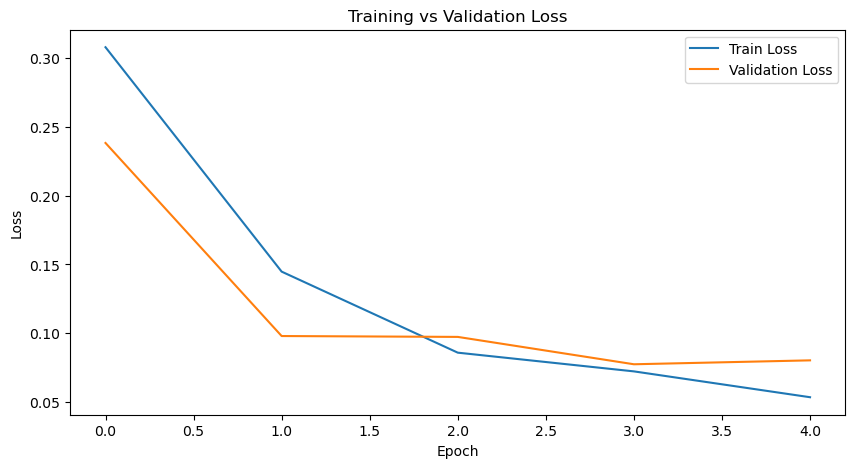

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")    
plt.show()

## E.

Di sini saya melakukan uji coba terhadap test set untuk menemukan test loss, test accuracy, prediksi test dataset yang terbagi jadi pendek (Cuma menunjukkan prediksi 20 sample saja) dan panjang (semua sample di test dataset sampai 1032), confusion matrix, dan classification report.

Saya mendapatkan test accuracy sebesar 0.98 (98%) dan test loss sebesar 0.08 (8%). Hasil ini menunjukkan bahwa prediksi modelnya sangat memuaskan.

Setelah itu, saya melakukan perbandingan antara prediction dan actual untuk masing-masing sample di test dataset yang dapat dilihat dan dicompare. 

Evaluasi juga dilakukann pada confusion matrix dan classification report. Model ini bekerja dengan sangat baik dengan precision, recall, dan accuracy yang tinggi, terutama untuk mendeteksi PNEUMONIA (recall 100%). Hal ini menunjukkan bahwa model ini secara efektif membedakan antara kasus NORMAL dan PNEUMONIA. Beberapa kesalahan klasifikasi sebagian besar merupakan true positives (memprediksi "PNEUMONIA" padahal sebenarnya "NORMAL"), yang lebih aman daripada memiliki false negatives (tidak mendiagnosis penyakit).

In [65]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


33/33 [==============================] - 0s 5ms/step - loss: 0.0785 - accuracy: 0.9758
Test Loss: 0.07852344214916229
Test Accuracy: 0.9757986664772034


In [66]:
# Prediksikan 20 sample random dari test dataset 
random_indices = np.random.choice(X_test.shape[0], 20, replace=False)
X_test_sample = X_test[random_indices]
y_test_sample = y_test[random_indices]

predictions = model.predict(X_test_sample)

for i in range(20):
    pred_class = label_class[np.argmax(predictions[i])]
    actual_class = label_class[np.argmax(y_test_sample[i])]
    print(f"Sample {i}: Prediction: {pred_class}, Actual: {actual_class}")



1/1 [==============================] - 0s 140ms/step
Sample 0: Prediction: NORMAL, Actual: NORMAL
Sample 1: Prediction: NORMAL, Actual: NORMAL
Sample 2: Prediction: NORMAL, Actual: NORMAL
Sample 3: Prediction: NORMAL, Actual: NORMAL
Sample 4: Prediction: NORMAL, Actual: NORMAL
Sample 5: Prediction: NORMAL, Actual: NORMAL
Sample 6: Prediction: NORMAL, Actual: NORMAL
Sample 7: Prediction: NORMAL, Actual: NORMAL
Sample 8: Prediction: NORMAL, Actual: NORMAL
Sample 9: Prediction: NORMAL, Actual: NORMAL
Sample 10: Prediction: NORMAL, Actual: NORMAL
Sample 11: Prediction: NORMAL, Actual: NORMAL
Sample 12: Prediction: NORMAL, Actual: NORMAL
Sample 13: Prediction: NORMAL, Actual: NORMAL
Sample 14: Prediction: NORMAL, Actual: NORMAL
Sample 15: Prediction: NORMAL, Actual: NORMAL
Sample 16: Prediction: NORMAL, Actual: NORMAL
Sample 17: Prediction: NORMAL, Actual: NORMAL
Sample 18: Prediction: NORMAL, Actual: NORMAL
Sample 19: Prediction: NORMAL, Actual: NORMAL


In [67]:
# Prediksi semua yang ada di test dataset
predictions = model.predict(X_test)

for i in range(len(X_test)):
    pred_class = label_class[np.round(predictions[i]).astype(int)[0]]
    actual_class = label_class[int(y_test[i])]
    print(f"Sample {i}: Prediction: {pred_class}, Actual: {actual_class}")


33/33 [==============================] - 0s 4ms/step
Sample 0: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 1: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 2: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 3: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 4: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 5: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 6: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 7: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 8: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 9: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 10: Prediction: NORMAL, Actual: NORMAL
Sample 11: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 12: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 13: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 14: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 15: Prediction: NORMAL, Actual: NORMAL
Sample 16: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 17: Prediction: PNEUMONIA, Actual: PNEUMONIA
Sample 18: Prediction: PNEUMONIA,

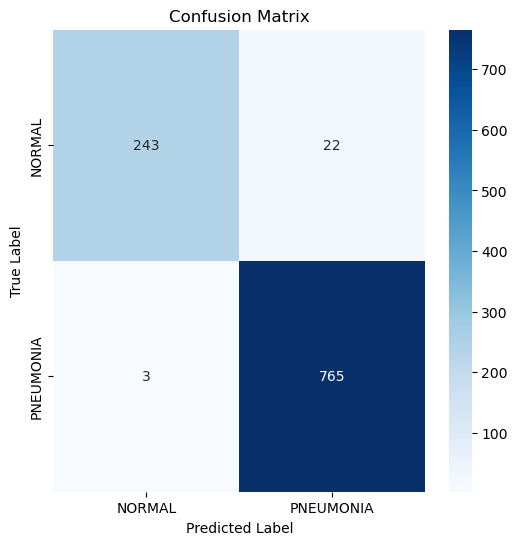

In [ ]:

pred_classes = (predictions > 0.5).astype(int)  # Threshold 0.5 binary classification
y_true = y_test 
conf_matrix = confusion_matrix(y_true, pred_classes)

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_class, yticklabels=label_class)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [69]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, pred_classes, target_names=label_class))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.92      0.95       265
   PNEUMONIA       0.97      1.00      0.98       768

    accuracy                           0.98      1033
   macro avg       0.98      0.96      0.97      1033
weighted avg       0.98      0.98      0.98      1033

